# (06) fMRI full brain

**Motivation**: Save fMRI results, full brain. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
from register.register import Register

## Init mice

In [3]:
mice = Mice(128, full_load=True, load_allen=True, load_parcel=True)
reg = Register(mice)

## Register anat

In [3]:
obj_all = reg.register_anat(
    save_results=True,
    anchor_ses=2,
)

100%|██████████| 10/10 [08:14<00:00, 49.49s/it]


## Copy masks, do xform

*Note*: These steps are copied from ```xform_steps.txt```

1. Copy from KABA to Yale:
```
scp /home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/masks/*.nii.gz hv88@spot.med.yale.internal:/data24/mri_group/elake_data_analyses/Hadi_ROIs/indiv3d/
```
2. Run ```./do_xform.sh``` on cuda5
3. Copy resulting 2d masks to _copy directory
```
scp -r hv88@spot.med.yale.internal:/data24/mri_group/elake_data_analyses/Hadi_ROIs /home/hadi/Documents/Ca-fMRI/Yale/_copy/
code
```
4. Copy masks from _copy directory to the masks_dir
    - 2d:
    ```
    find /home/hadi/Documents/Ca-fMRI/Yale/_copy/ -type f -name "*indiv2d*.nii.gz" -exec cp {} /home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/masks/ \;
    ```
    - BIS:
    ```
    find /home/hadi/Documents/Ca-fMRI/Yale/_copy/ -type f -name "*-BIS_*.nii.gz" -exec cp {} /home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/masks/ \;
    ```

## Debugged: ```get_accepted_regions()```

### CA2

In [4]:
mode = 'ca2'
reg.set_mode(mode)
accepted = reg.get_accepted_regions()

Name: cols . . . a total of: 146 regions accepted, 50 regions rejected.
accept ratio: 74.49 %, reject ratio: 25.51 %, using a presence threshold of 50.0 %

In [5]:
top, flat = mice.parcel.load_top_flat()

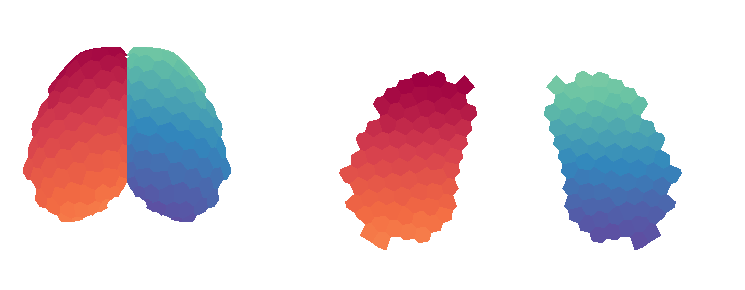

In [6]:
fig, axes = create_figure(1, 2, (8, 3), width_ratios=[1, 1.4])
axes[0].imshow(mwh(~np.isin(top, accepted['acc']), top), cmap='Spectral')
axes[1].imshow(mwh(~np.isin(flat, accepted['acc']), flat), cmap='Spectral')
remove_ticks(axes)
plt.show()

### BOLD

In [7]:
mode = 'bold'
reg.set_mode(mode)
accepted = reg.get_accepted_regions()

Name: brain . . . a total of: 2766 regions accepted, 16 regions rejected.
accept ratio: 99.42 %, reject ratio: 0.58 %, using a presence threshold of 50.0 %

## Debug: ```get_tsnr_masks()```

### q_bold = 0.05

In [8]:
tsnr_masks = reg.get_tsnr_masks(0.05)

Name: brain . . . a total of: 2766 regions accepted, 16 regions rejected.
accept ratio: 99.42 %, reject ratio: 0.58 %, using a presence threshold of 50.0 %

In [9]:
portion_rois = {}
for k, m in tsnr_masks['bold'].items():
    key = mice.get_key(*mice.looper[k][:2])
    f = f"{key}_space-indiv3d_eroded.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    obj = ants.image_read(f).numpy().astype(int)
    portion_rois[k] = len(unique_idxs(obj[m])) / len(unique_idxs(obj))

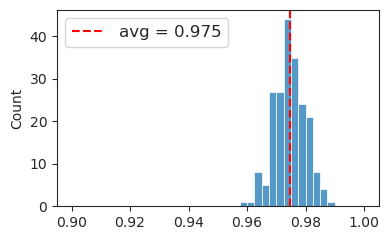

In [10]:
fig, ax = create_figure(1, 1, (4, 2.5))
sns.histplot(list(portion_rois.values()), bins=np.linspace(0.9, 1, 41), ax=ax)
_x = np.mean(list(portion_rois.values()))
ax.axvline(_x, color='r', ls='--', label=f"avg = {_x:0.3f}")
ax.legend(loc='upper left', fontsize=12)
plt.show()

### q_bold = 0.1

In [11]:
tsnr_masks = reg.get_tsnr_masks(0.1)

Name: brain . . . a total of: 2766 regions accepted, 16 regions rejected.
accept ratio: 99.42 %, reject ratio: 0.58 %, using a presence threshold of 50.0 %

In [12]:
portion_rois = {}
for k, m in tsnr_masks['bold'].items():
    key = mice.get_key(*mice.looper[k][:2])
    f = f"{key}_space-indiv3d_eroded.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    obj = ants.image_read(f).numpy().astype(int)
    portion_rois[k] = len(unique_idxs(obj[m])) / len(unique_idxs(obj))

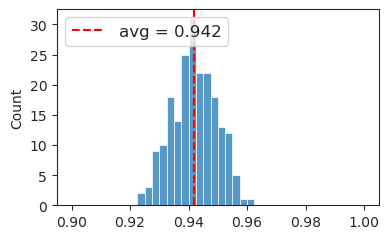

In [13]:
fig, ax = create_figure(1, 1, (4, 2.5))
sns.histplot(list(portion_rois.values()), bins=np.linspace(0.9, 1, 41), ax=ax)
_x = np.mean(list(portion_rois.values()))
ax.axvline(_x, color='r', ls='--', label=f"avg = {_x:0.3f}")
ax.legend(loc='upper left', fontsize=12)
plt.show()

## Final step: ```run_register.sh```

Running this to organize functional data:
```
./run_register.sh 128 3 0 0.5
```

## Note on parcel.df

We have both ```id``` and ```region``` columns. ```id``` means region id, something to extract the ROI masks from parcellation results. These are unique. In other words, each ROI has a unique ```id```. On the other hand, ```region``` has some sort of degenracy. For instance, there are only 128 ```region```s, but with different layer and hemisphere ids for cortex. As another example, there are only 72 unique ```region```s for HIP, which means 144 unique ```id```s in total. See below.

In [4]:
_df = mice.parcel.df.loc[mice.parcel.df['acro'] == 'HIP']
_df

,id,acro,hemis,region,layer
1056,1057,HIP,1,1057,-1
1057,1058,HIP,1,1058,-1
1058,1059,HIP,1,1059,-1
1059,1060,HIP,1,1060,-1
1060,1061,HIP,1,1061,-1
...,...,...,...,...,...
1195,1196,HIP,2,1124,-1
1196,1197,HIP,2,1125,-1
1197,1198,HIP,2,1126,-1
1198,1199,HIP,2,1127,-1


In [5]:
len(_df['region'].unique())

72

## Verify (shapes, etc)

### CA2

In [4]:
n_good, shapes = [], []
for k, f in mice.ca.items():
    good = np.isnan(f[:]).sum(1) == 0
    n_good.append(good.sum())
    shapes.append(f.shape)
set(i for i, j in shapes)

{146}

In [5]:
collections.Counter(shapes).most_common()

[((146, 6000), 106), ((146, 5999), 5), ((146, 5200), 1)]

In [6]:
collections.Counter(n_good).most_common()

[
    (141, 24),
    (145, 18),
    (144, 14),
    (138, 11),
    (139, 9),
    (146, 8),
    (137, 7),
    (134, 6),
    (135, 4),
    (140, 3),
    (142, 3),
    (130, 2),
    (133, 2),
    (131, 1)
]

In [26]:
k = 'sub-SLC01_ses-1_run-7'
x = mice.ca[k][:]
x.shape

(146, 6000)

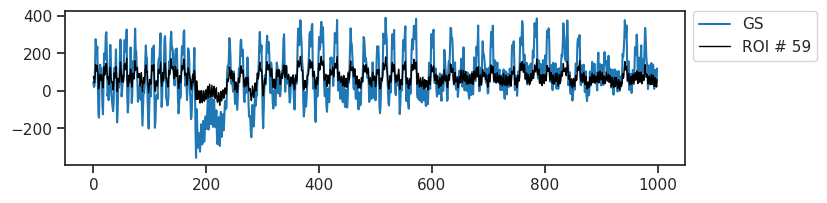

In [27]:
fig, ax = create_figure(1, 1, (8, 2))
ax.plot(x[59][500:1500], color='C0', label='GS')
ax.plot(np.nanmean(x, 0)[500:1500], color='k', lw=1.0, label='ROI # 59')
ax.legend(bbox_to_anchor=(1, 1.05))
plt.show()

### BOLD

In [28]:
n_good, shapes = [], []
for k, f in mice.bold.items():
    good = np.isnan(f[:]).sum(1) == 0
    n_good.append(good.sum())
    shapes.append(f.shape)
set(i for i, j in shapes)

{2766}

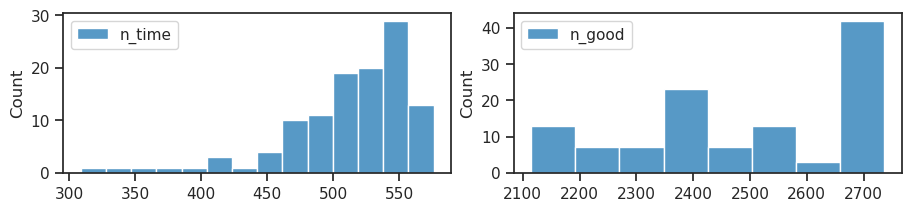

In [29]:
fig, axes = create_figure(1, 2, (9, 2), layout='constrained')
sns.histplot([j for i, j in shapes], label='n_time', ax=axes[0])
sns.histplot(n_good, label='n_good', ax=axes[1])
for ax in axes.flat:
    ax.legend()
plt.show()

In [30]:
k = 'sub-SLC01_ses-1_run-7'
x = mice.bold[k][:]
x.shape

(2766, 499)

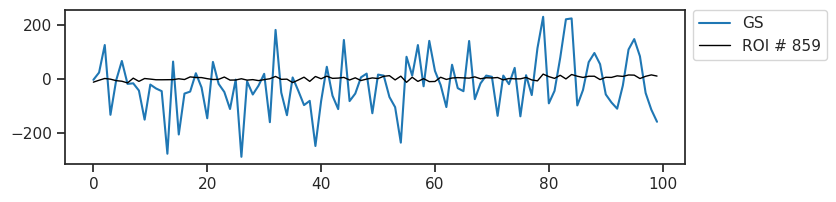

In [31]:
fig, ax = create_figure(1, 1, (8, 2))
ax.plot(x[859][50:150], color='C0', label='GS')
ax.plot(np.nanmean(x, 0)[50:150], color='k', lw=1.0, label='ROI # 859')
ax.legend(bbox_to_anchor=(1, 1.05))
plt.show()

## Etc (node lookup and other things)

In [5]:
os.listdir(pjoin(tmp_dir, 'CafMRI-Selected'))

['topview_mask.npy', 'node2area.npy', 'roi_lookup.npy', 'topview.npy']

In [14]:
x = np.load(pjoin(tmp_dir, 'CafMRI-Selected', 'roi_lookup.npy'), allow_pickle=True).item()

In [16]:
list(x)

['ca2', 'bold']

In [17]:
x['ca2']

{
    0: '1-56-0',
    1: '1-57-0',
    2: '1-59-0',
    3: '1-60-0',
    4: '1-66-0',
    5: '1-69-0',
    6: '1-70-0',
    7: '1-71-0',
    8: '1-72-0',
    9: '1-74-0',
    10: '1-75-0',
    11: '1-77-0',
    12: '1-78-0',
    13: '1-80-0',
    14: '1-84-0',
    15: '1-86-0',
    16: '1-89-0',
    17: '1-91-0',
    18: '1-93-0',
    19: '1-94-0',
    20: '1-95-0',
    21: '1-96-0',
    22: '1-97-0',
    23: '1-98-0',
    24: '1-100-0',
    25: '1-101-0',
    26: '1-103-0',
    27: '1-108-0',
    28: '1-110-0',
    29: '1-112-0',
    30: '1-114-0',
    31: '1-115-0',
    32: '1-116-0',
    33: '1-117-0',
    34: '1-118-0',
    35: '1-119-0',
    36: '1-120-0',
    37: '1-121-0',
    38: '1-122-0',
    39: '1-123-0',
    40: '1-132-0',
    41: '1-133-0',
    42: '1-134-0',
    43: '1-137-0',
    44: '1-138-0',
    45: '1-139-0',
    46: '1-141-0',
    47: '1-142-0',
    48: '1-143-0',
    49: '1-144-0',
    50: '1-145-0',
    51: '1-146-0',
    52: '1-149-0',
    53: '1-151-0',
    54: '1-157-0',
    55: '1-158-0',
    56: '1-159-0',
    57: '1-160-0',
    58: '1-163-0',
    59: '1-166-0',
    60: '1-167-0',
    61: '1-168-0',
    62: '1-169-0',
    63: '1-170-0',
    64: '1-171-0',
    65: '1-173-0',
    66: '1-175-0',
    67: '1-176-0',
    68: '1-179-0',
    69: '1-182-0',
    70: '1-183-0',
    71: '1-184-0',
    72: '1-185-0',
    73: '1-186-0',
    74: '1-188-0',
    75: '1-190-0',
    76: '1-191-0',
    77: '1-194-0',
    78: '1-195-0',
    79: '1-197-0',
    80: '1-198-0',
    81: '1-202-0',
    82: '1-203-0',
    83: '1-204-0',
    84: '1-205-0',
    85: '1-206-0',
    86: '1-208-0',
    87: '1-210-0',
    88: '1-213-0',
    89: '1-214-0',
    90: '1-217-0',
    91: '1-218-0',
    92: '1-220-0',
    93: '1-223-0',
    94: '1-224-0',
    95: '1-225-0',
    96: '1-228-0',
    97: '1-229-0',
    98: '1-230-0',
    99: '1-232-0',
    100: '1-234-0',
    101: '1-237-0',
    102: '1-238-0',
    103: '1-240-0',
    104: '1-242-0',
    105: '1-243-0',
    106: '1-244-0',
    107: '1-246-0',
    108: '1-247-0',
    109: '1-248-0',
    110: '1-249-0',
    111: '1-252-0',
    112: '1-254-0',
    113: '1-255-0',
    114: '1-256-0',
    115: '1-260-0',
    116: '1-261-0',
    117: '1-263-0',
    118: '1-264-0',
    119: '1-265-0',
    120: '1-268-0',
    121: '1-269-0',
    122: '1-271-0',
    123: '1-272-0',
    124: '1-274-0',
    125: '1-276-0',
    126: '1-278-0',
    127: '1-280-0',
    128: '1-282-0',
    129: '1-283-0',
    130: '1-284-0',
    131: '1-286-0',
    132: '1-287-0',
    133: '1-288-0',
    134: '1-289-0',
    135: '1-290-0',
    136: '1-294-0',
    137: '1-295-0',
    138: '1-297-0',
    139: '1-298-0',
    140: '1-299-0',
    141: '1-301-0',
    142: '1-302-0',
    143: '1-303-0',
    144: '1-306-0',
    145: '1-307-0',
    146: '1-309-0',
    147: '1-310-0',
    148: '1-312-0',
    149: '1-314-0',
    150: '1-315-0',
    151: '1-316-0',
    152: '1-317-0',
    153: '1-319-0',
    154: '1-322-0',
    155: '1-323-0',
    156: '1-324-0',
    157: '1-325-0',
    158: '1-327-0',
    159: '1-328-0',
    160: '1-330-0',
    161: '1-331-0',
    162: '1-332-0',
    163: '1-334-0',
    164: '1-336-0',
    165: '1-337-0',
    166: '1-339-0',
    167: '1-341-0',
    168: '1-342-0',
    169: '1-344-0',
    170: '1-346-0',
    171: '1-347-0',
    172: '1-348-0',
    173: '1-349-0',
    174: '1-351-0',
    175: '1-353-0',
    176: '1-354-0',
    177: '1-356-0',
    178: '1-357-0',
    179: '1-358-0',
    180: '1-360-0',
    181: '1-362-0',
    182: '1-364-0',
    183: '1-365-0',
    184: '1-366-0',
    185: '1-367-0',
    186: '1-368-0',
    187: '1-369-0',
    188: '1-373-0',
    189: '1-374-0',
    190: '1-375-0',
    191: '1-376-0',
    192: '1-377-0',
    193: '1-378-0',
    194: '1-380-0',
    195: '1-382-0',
    196: '1-383-0',
    197: '1-384-0',
    198: '1-385-0',
    199: '1-386-0',
    200: '1-388-0',
    201: '1-390-0',
    202: '1-392-0',
    203: '1-393-0',
    204: '1-395-0',
    205: '1-396-0',
    206: '1-

In [25]:
os.listdir(mice.cfg.main_dir)

[
    'ca2',
    'roi_lookup.npy',
    'parcellation',
    'log',
    'masks',
    'combine_meta.npy',
    'config.json',
    'bold',
    'results'
]

In [31]:
x = np.load(pjoin(mice.cfg.main_dir, 'roi_lookup.npy'), allow_pickle=True).item()

In [32]:
list(x)

['ca2', 'bold']

In [39]:
len(x['ca2']), len(x['bold'])

(146, 2766)

In [37]:
mice.parcel.df.to_csv(pjoin(tmp_dir, 'CafMRI-Selected', 'roi_info.csv'), sep='\t')

## --- Ignore ---

In [7]:
list(mice.parcel.results)

[
    'cols',
    'brain',
    'cortex',
    'subcortex',
    'cortex-top',
    'brain-eroded',
    'nonzero-idxs_parcel2d-flat',
    'nonzero-idxs_parcel2d-top',
    'nonzero-idxs_parcel3d',
    'region-idxs_parcel2d-flat',
    'region-idxs_parcel2d-top',
    'region-idxs_parcel3d',
    'shape_parcel2d-flat',
    'shape_parcel2d-top',
    'shape_parcel3d'
]

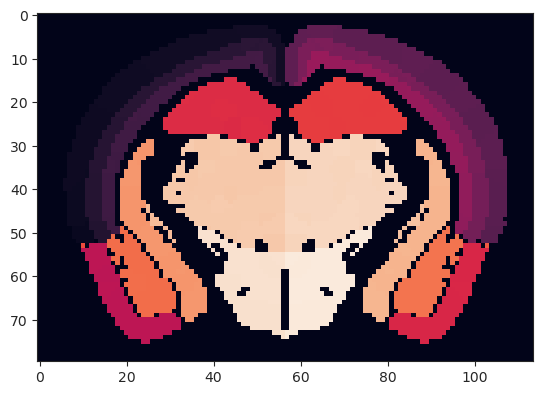

In [11]:
plt.imshow(mice.parcel['brain'][70]);

In [4]:
self = reg

In [53]:
regions_obj_name = 'brain'
anat_masks = self.mice.mask3d
regions = self.mice.parcel[regions_obj_name]

regions = regions[regions.nonzero()]
regions = np.unique(regions)
len(regions)

2782

2782

In [54]:
for key, anat in self.mice.T1w.items():
    m = anat_masks[key].load_ants()
    m = m.numpy().astype(bool)
    obj_masks = self.load_obj_masks(key)
    
    obj = obj_masks[regions_obj_name].numpy() * m
    
    break

In [16]:
## Task: make sure brain and eroded have the exact same regions for all animals/sessions

['brain']

In [18]:
list(unique_idxs(obj_masks['brain'].numpy())) == list(unique_idxs(obj_masks['eroded'].numpy()))

False

In [19]:
a = list(unique_idxs(obj_masks['brain'].numpy()))
b = list(unique_idxs(obj_masks['eroded'].numpy()))

In [20]:
len(a), len(b)

(2770, 2674)

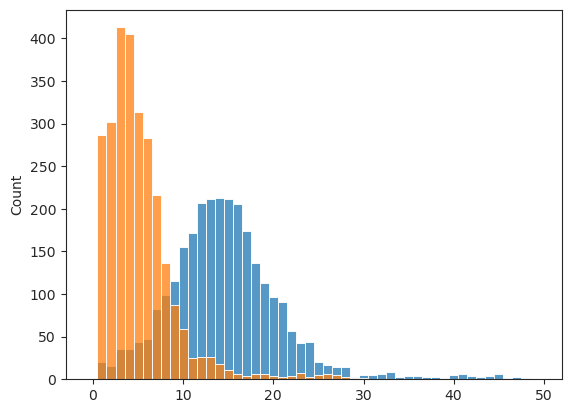

In [25]:
bins = np.linspace(0, 50, 51) - 0.5
sns.histplot([len(v) for v in unique_idxs(obj_masks['brain'].numpy()).values()], bins=bins, label='brain')
sns.histplot([len(v) for v in unique_idxs(obj_masks['eroded'].numpy()).values()], bins=bins, label='eroded');

In [56]:
len(regions)

2782

In [34]:
hcl

array([[ 1,  1,  0],
       [ 1,  2,  0],
       [ 1,  3,  0],
       ...,
       [ 8, 92,  0],
       [ 8, 93,  0],
       [ 8, 94,  0]])

[<matplotlib.lines.Line2D object at 0x7f259d2fd580>]

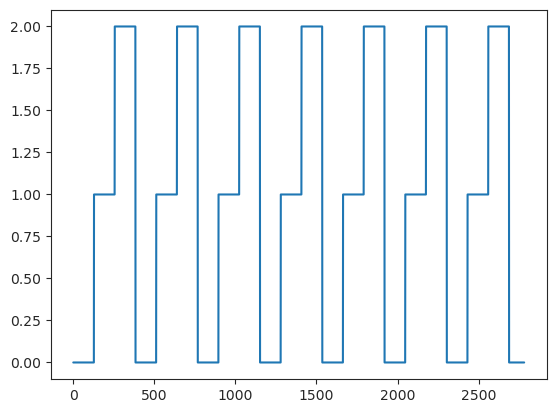

In [33]:
plt.plot(hcl[:, 2])

In [41]:
mice.parcel.decode(1265)

array([[  4, 113,   0]])

In [61]:
self.roi_cutoff

0

In [58]:
			_info = self.mice.parcel.df.loc[
				mice.parcel.df['id'].isin(sizes)]

In [60]:
self.mice.parcel.df

,id,acro,hemis,region,layer
0,1,Isocortex,1,1,0
1,2,Isocortex,1,2,0
2,3,Isocortex,1,3,0
3,4,Isocortex,1,4,0
4,5,Isocortex,1,5,0
...,...,...,...,...,...
2777,2778,CB,2,2610,-1
2778,2779,CB,2,2611,-1
2779,2780,CB,2,2612,-1
2780,2781,CB,2,2613,-1


In [59]:
_info

,id,acro,hemis,region,layer
0,1,Isocortex,1,1,0
1,2,Isocortex,1,2,0
2,3,Isocortex,1,3,0
3,4,Isocortex,1,4,0
4,5,Isocortex,1,5,0
...,...,...,...,...,...
2777,2778,CB,2,2610,-1
2778,2779,CB,2,2611,-1
2779,2780,CB,2,2612,-1
2780,2781,CB,2,2613,-1


In [43]:
mice.parcel.get(1)

{'id': 1, 'acro': 'Isocortex', 'hemis': 1, 'region': 1, 'layer': 0}

In [47]:
len()

2768

<matplotlib.image.AxesImage object at 0x7f259d2b5af0>

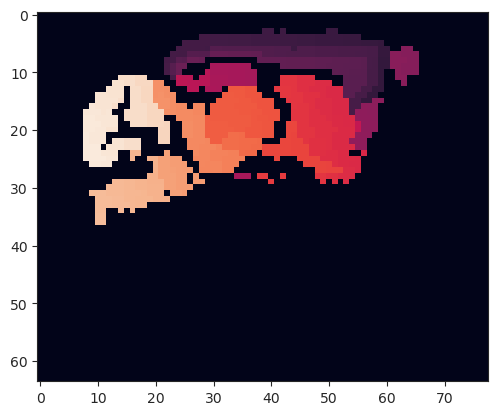

In [46]:
plt.imshow(obj[40])

In [48]:
sizes = {
    r: len(v) for r, v in
    unique_idxs(obj).items()
}

<Axes: ylabel='Count'>

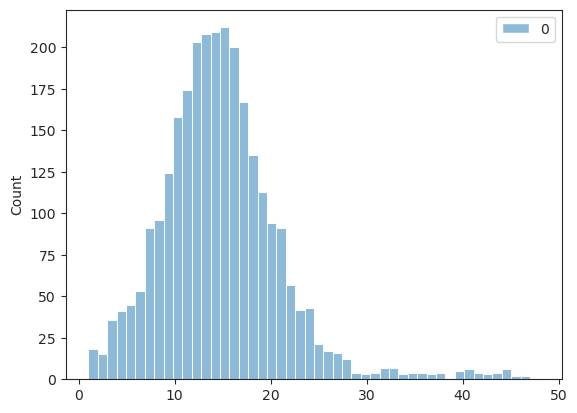

In [51]:
sns.histplot(sizes.values())

In [52]:
list(obj_masks)

['brain', 'eroded']

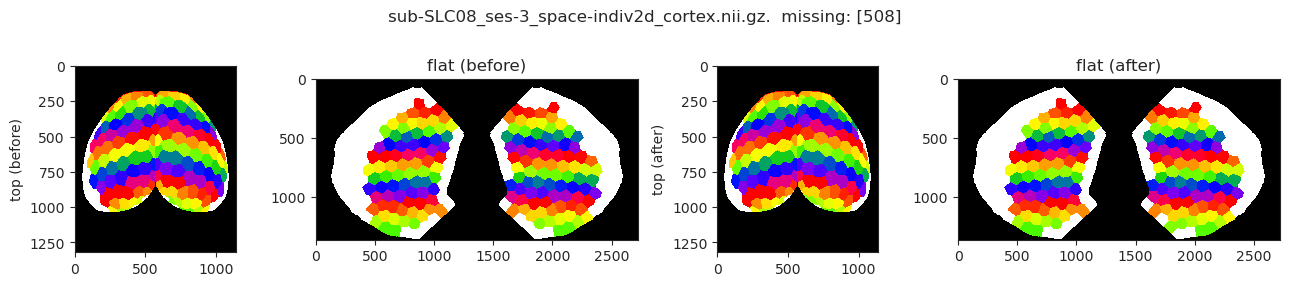

In [71]:
mice.parcel.fill_rois_2d(dry_run=True)